Notebook used to generate supplemental figure 3 and main text figure 6

In [1]:
import glob
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import BootstrapFunctions as bsf
from matplotlib.font_manager import FontProperties
import matplotlib
import seaborn as sns
fontpath = '/Users/seshu/Library/Fonts/TorontoSubwayLight.otf'
labelfont = FontProperties(fname=fontpath,size=10)

In [2]:
#List out the perturbation types: u is up, d is down, n is none. l for lambda, g for gamma.  Add 1,2 to balance the neutral points
pertcases = {"lngn":[0,1,2],"lngu":[3,4,5],"lngd":[6,7,8],
             "lugn":[9,10,11],"lugu":[12,13,14],"lugd":[15,16,17],
             "ldgn":[18,19,20],"ldgu":[21,22,23],"ldgd":[24,25,26]}
oneparamperts = pertcases["lngn"]+pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
no_nonperts = pertcases["lugn"]+pertcases["ldgn"]+pertcases["lngu"]+pertcases["lngd"]
inv_pertcases = {v_int:k for k, v in pertcases.items() for v_int in v}

In [3]:
paramlist = ['lambda','beta_x','gamma','beta_y','alpha','beta_z','nx','Kx','ny','Ky','offset']
byfilelist = ['fileN','fileda','filedb','sysname']

In [4]:
standard_columns = ['E[rhoxy]','E[CVx/CVy]','E[<x>]','E[<y>]','E[<F_x>]','E[<F_y>]',
                    '97.5% (rhoxy)','2.5% (rhoxy)','97.5% (CVx/CVy)','2.5% (CVx/CVy)',
                    '97.5% (<x>)','2.5% (<x>)','97.5% (<y>)','2.5% (<y>)',
                    '97.5% (<F_x>)','2.5% (<F_x>)','97.5% (<F_y>)','2.5% (<F_y>)',
                    'F_y at avg','F_x at avg','Var[lambda]','Var[gamma]','E[lambda]','E[gamma]',
                    'consistent fy signs (avg)','consistent fy signs (at avg)',
                    'consistent fx signs (avg)','consistent fx signs (at avg)']
parentfolders = ['Directy_largeNspread']

In [5]:
def rate_x(y,z,lamda,alpha,ny,Ky,o):
    return lamda*(z+alpha*y**ny/(Ky**ny+y**ny)+o)
def sensitivty_x(x,y,z,lamda,alpha,nx,Kx,ny,Ky,o):
    return nx*(lamda/rate_x(y,z,lamda,alpha,ny,Ky,o))*((Kx**nx)*(x**nx)/(Kx**nx+x**nx)**2)
def sensitivty_y(y,z,lamda,alpha,ny,Ky,o):
    return ny*(lamda/rate_x(y,z,lamda,alpha,ny,Ky,o))*((Ky**ny)*(y**ny)/(Ky**ny+y**ny)**2)

In [6]:
for parent in parentfolders:
    folders = glob.glob(f'Data/{parent}/*/*')
    dat = []
    failedsims = []
    bootstrapdicts = []
    for i,folder in enumerate(folders):
        files = glob.glob(folder+'/*data.csv',recursive=True)
        for j,f in enumerate(files):
            data = pd.read_csv(f)
            data = data.reset_index().rename(columns={'index':'perturbation'})
            numstrings = f.split("_")[-2].split('n')
            if (data[['Cov Bal xx','Cov Bal yy','Cov Bal xy','Cov Bal xz','Cov Bal yz','Cov Bal zz']] > 0.05).any(axis=1).any():
                failedsims.append(f)
                continue
            if 'offset' not in data:
                data['offset'] = 0
            dat.append(data)
            bsdict = bsf.pertexp_interpret(data,'all',analysed_columns=['<x>','<y>','<z>',"<F_x>","<F_y>"])
            fxs = sensitivty_x(data['<x>'].astype(float),data['<y>'].astype(float),data['<z>'].astype(float),
                                            data['lambda'],data['alpha'],data['nx'].astype(float),data['Kx'],
                                            data['ny'].astype(float),data['Ky'],data['offset'])
            fys = sensitivty_y(data['<y>'].astype(float),data['<z>'].astype(float),
                                            data['lambda'],data['alpha'].astype(float),data['ny'].astype(float),
                                            data['Ky'].astype(float),data['offset'])
            bsdict['F_y at avg'] = fys.mean()
            bsdict['F_x at avg'] = fxs.mean()
            bsdict['consistent fy signs (avg)'] = np.sum(np.sign(data['<F_y>']))
            bsdict['consistent fx signs (avg)'] = np.sum(np.sign(1-data['<F_x>']))
            bsdict['consistent fy signs (at avg)'] = np.sum(np.sign(fys))
            bsdict['consistent fx signs (at avg)'] = np.sum(np.sign(1-fxs))
            bsdict['fileN'] = float(numstrings[0])
            bsdict['fileda'] = float(numstrings[1])
            bsdict['filedb'] = float(numstrings[2])
            bsdict['sysname'] = "/".join(f.split("/")[:-1])
            for p in paramlist:
                try:
                    bsdict[p] = data[p][0]
                except KeyError:
                    bsdict[p] = 0
            bootstrapdicts.append(bsdict)
    directory = f"/".join(f.split("/")[:-3])
    bootstrapped_res = pd.DataFrame(bootstrapdicts)
    bootstrapped_res.set_index(["fileN",'fileda','filedb','sysname'],inplace=True)
    bootstrapped_res[standard_columns].to_csv(f'{directory}/{directory.split("/")[-1]}_standard_form.csv')
    print(f"Finished {directory}")
    with open(f'{directory}/{directory.split("/")[-1]}_failedsims.txt','w') as f:
        for path in failedsims:
            f.write(f"{path}\n")

Finished Data/Directy_largeNspread


In [7]:
print(bootstrapped_res.columns.to_list())

['E[rhoxy]', '2.5% (rhoxy)', '50% (rhoxy)', '97.5% (rhoxy)', 'E[CVx/CVy]', '2.5% (CVx/CVy)', '50% (CVx/CVy)', '97.5% (CVx/CVy)', 'E[<x>]', 'E[<y>]', 'E[<z>]', 'E[<F_x>]', 'E[<F_y>]', '2.5% (<x>)', '2.5% (<y>)', '2.5% (<z>)', '2.5% (<F_x>)', '2.5% (<F_y>)', '97.5% (<x>)', '97.5% (<y>)', '97.5% (<z>)', '97.5% (<F_x>)', '97.5% (<F_y>)', '50% (<x>)', '50% (<y>)', '50% (<z>)', '50% (<F_x>)', '50% (<F_y>)', 'Var[<x>]', 'Var[<y>]', 'Var[<z>]', 'Var[<F_x>]', 'Var[<F_y>]', '2.5% (Var[<x>])', '2.5% (Var[<y>])', '2.5% (Var[<z>])', '2.5% (Var[<F_x>])', '2.5% (Var[<F_y>])', '97.5% (Var[<x>])', '97.5% (Var[<y>])', '97.5% (Var[<z>])', '97.5% (Var[<F_x>])', '97.5% (Var[<F_y>])', '50% (Var[<x>])', '50% (Var[<y>])', '50% (Var[<z>])', '50% (Var[<F_x>])', '50% (Var[<F_y>])', 'E[eta_xx]', '2.5% (eta_xx)', '50% (eta_xx)', '97.5% (eta_xx)', 'E[eta_yy]', '2.5% (eta_yy)', '50% (eta_yy)', '97.5% (eta_yy)', 'E[eta_xy]', '2.5% (eta_xy)', '50% (eta_xy)', '97.5% (eta_xy)', 'E[eta_gg inf]', '2.5% eta_gg inf', '50% e

In [8]:
bootstrapped_res[paramlist+['E[<F_x>]','E[<F_y>]','F_y at avg','F_x at avg','consistent fy signs (avg)','consistent fx signs (avg)',
                  'consistent fy signs (at avg)','consistent fx signs (at avg)']].to_csv(f'Data/parameters/Directy_both.csv')

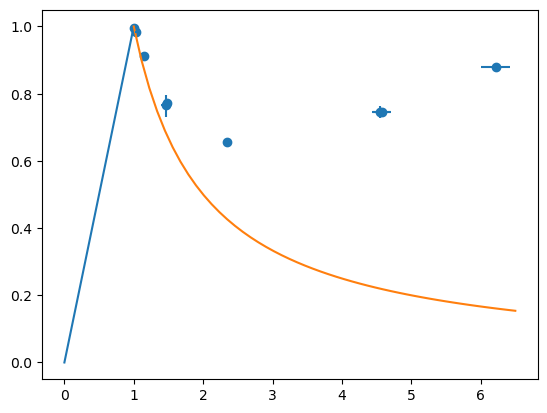

In [9]:
plt.scatter(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'])
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.plot(np.linspace(1,6.5),1/np.linspace(1,6.5))
plt.errorbar(bootstrapped_res['E[CVx/CVy]'],bootstrapped_res['E[rhoxy]'],
                xerr=[bootstrapped_res['E[CVx/CVy]']-bootstrapped_res['2.5% (CVx/CVy)'],
                        bootstrapped_res['97.5% (CVx/CVy)']-bootstrapped_res['E[CVx/CVy]']],
                yerr=[bootstrapped_res['E[rhoxy]']-bootstrapped_res['2.5% (rhoxy)'],
                        bootstrapped_res['97.5% (rhoxy)']-bootstrapped_res['E[rhoxy]']],fmt='None')
plt.show()

(np.float64(0.9435250098988041), np.float64(0.9426957064394366), np.float64(0.9511376597587254)) o 0.001
(np.float64(0.7061292955874321), np.float64(0.6545359546796026), np.float64(0.9461375334300088)) D 0.01


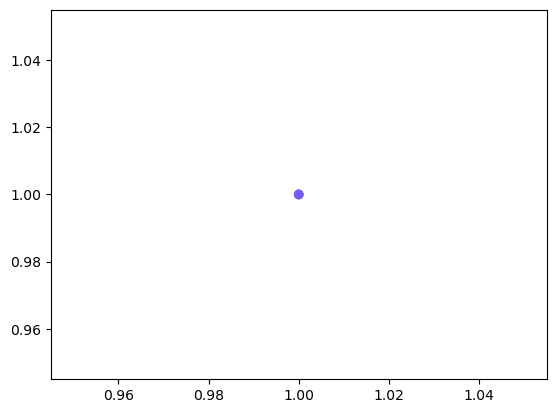

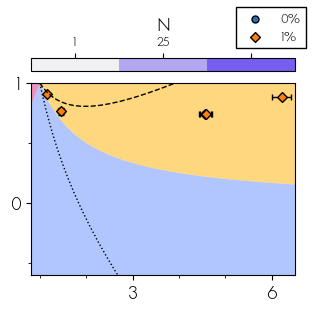

In [15]:
cmap = matplotlib.colors.ListedColormap(sns.light_palette('#785ef0',n_colors=3))
norm = matplotlib.colors.BoundaryNorm([-10,10,30,50],cmap.N)
throwawayfig,tax = plt.subplots()
cbvals = tax.scatter([1,1,1],[1,1,1],c=[20,40,60],cmap=cmap,norm=norm)


fig1b,ax1b = plt.subplots(figsize=(8/2.54,8/2.54))
ax1b.spines.left.set_color('k')
ax1b.spines.right.set_color('k')
ax1b.spines.bottom.set_color('k')
ax1b.spines.top.set_color('k')
ax1b.xaxis.set_ticks_position('bottom')
ax1b.yaxis.set_ticks_position('left')


cvals = sns.light_palette('#785ef0',n_colors=3)
colordict = {1:cvals[0],25:cvals[1],81:cvals[2]}
markers = ['o','D','s']
for (cval,marker),da in zip(zip(cvals,markers),[0.001,0.01]):
    print(cval,marker,da)
    curated = bootstrapped_res[bootstrapped_res.index.get_level_values('fileda')==da]
    g = ax1b.scatter(curated['E[CVx/CVy]'],curated['E[rhoxy]'],marker=marker,
                edgecolors='k',s=25,zorder=1,label=f'{da*100:.0f}%')

    ax1b.errorbar(curated['E[CVx/CVy]'],curated['E[rhoxy]'],
                    xerr=bsf.CV_bars(curated),
                    yerr=bsf.rho_bars(curated),
                    capsize=2,fmt='None',zorder=0,elinewidth=1,c='k',alpha=1)

fx = curated['F_x at avg'].iloc[0:3].mean()
fy = curated['F_y at avg'].iloc[0:3].mean()
Nvals = curated.index.get_level_values('fileN').unique()
ndomain = np.logspace(-4,10,100)

eta_xy_pred = 1+(1-fx)*fy*Nvals
eta_xx_pred = 1+(fy**2)*Nvals
eta_yy_pred = 1+(1-fx)**2*Nvals

eta_xydomain= 1+(1-fx)*fy*ndomain
eta_xxdomain = 1+(fy**2)*ndomain
eta_yydomain = 1+(1-fx)**2*ndomain

rho_pred = eta_xy_pred/(np.sqrt(eta_xx_pred*eta_yy_pred))
CV_ratio_pred = np.sqrt(eta_xx_pred/eta_yy_pred)

rho_domain = eta_xydomain/(np.sqrt(eta_xxdomain*eta_yydomain))
CV_ratio_domain = np.sqrt(eta_xxdomain/eta_yydomain)


ax1b.plot(CV_ratio_domain,rho_domain,'k--',linewidth=1)

fx = curated['E[<F_x>]'].iloc[0:3].mean()
fy = curated['E[<F_y>]'].iloc[0:3].mean()
Nvals = curated.index.get_level_values('fileN').unique()
ndomain = np.logspace(-4,10,100)

eta_xy_pred = 1+(1-fx)*fy*Nvals
eta_xx_pred = 1+(fy**2)*Nvals
eta_yy_pred = 1+(1-fx)**2*Nvals

eta_xydomain= 1+(1-fx)*fy*ndomain
eta_xxdomain = 1+(fy**2)*ndomain
eta_yydomain = 1+(1-fx)**2*ndomain

rho_pred = eta_xy_pred/(np.sqrt(eta_xx_pred*eta_yy_pred))
CV_ratio_pred = np.sqrt(eta_xx_pred/eta_yy_pred)

rho_domain = eta_xydomain/(np.sqrt(eta_xxdomain*eta_yydomain))
CV_ratio_domain = np.sqrt(eta_xxdomain/eta_yydomain)


ax1b.plot(CV_ratio_domain,rho_domain,'k:',linewidth=1)
#ax1b.scatter(CV_ratio_pred,rho_pred,marker='v',
#            c=Nvals,edgecolors='k',s=40,zorder=3,linewidths=0.5,cmap='bone')


#constraint lines
straightline = np.linspace(0,1)
curvedline = np.linspace(1,10)
#ax1b.plot(straightline,straightline,color='k',linestyle='-',linewidth=1,alpha=1)
#ax1b.plot(curvedline,1/curvedline,'-',color='k',linewidth=1,alpha=1)

#positiveprotein
ax1b.fill_between(straightline,straightline,1,color='#DC267F',edgecolor='None',zorder=-1,alpha=0.5)
#negproteinbelow
ax1b.fill_between(np.concatenate([straightline,curvedline]),np.concatenate([straightline,1/curvedline]),-1,color='#648FFF',zorder=-1,alpha=0.5,edgecolor='None')
#negproteinabove
ax1b.fill_between(curvedline,1,1/curvedline,facecolor='#ffb000',zorder=-1,alpha=0.5,edgecolor='None')
labelfont.set_size(14)
#Set axes
ax1b.set_xticks([3,6])
ax1b.set_xticks([1,2,4,5],minor=True)
ax1b.set_xticklabels([r'3',r'6'],size=10,fontproperties=labelfont)

ax1b.set_yticks([0,1])
ax1b.set_yticks([-0.5,0.5],minor=True)
ax1b.set_yticklabels([r'0',r'1'],size=10,fontproperties=labelfont)

ax1b.set_xlim(0.8,6.5)
ax1b.set_ylim(-0.6,1)
cb = fig1b.colorbar(cbvals,ax=ax1b,location='top')
cb.set_label(r'N',fontproperties=labelfont)
cb.ax.set_xticks([0,20,40])
cb.ax.set_xticks([],minor=True)
cb.ax.set_xticklabels([r'1',r'25',r'81'],size=10,fontproperties=labelfont)
for tick in cb.ax.get_xticklabels():
    tick.set_fontproperties(labelfont)
    tick.set_fontsize(10)
labelfont.set_size(10)
legend = fig1b.legend(loc='upper right',
                      prop=labelfont,facecolor='w',edgecolor='k',framealpha=1,fancybox=False)
for t in legend.get_texts():
    t.set_ha('right') # ha is alias for horizontalalignment
fig1b.tight_layout()


In [227]:
curated = pd.read_csv('stoch_violator_bothint_rhocv.csv')
ex = pd.read_csv('stoch_violator_bothint_perts.csv')

In [162]:
bootstrapped_res

E[rhoxy]  \
fileN  fileda filedb  sysname                                                   
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0  0.767254   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0  0.772834   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0  0.745865   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0  0.657404   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0  0.879763   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0  0.911124   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0  0.982464   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0  0.995358   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0  0.744335   

                                                                     2.5% (rhoxy)  \
fileN  fileda filedb  sysname                                                       
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0      0.729812   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0      0.769122   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0      0.726335   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0      0.652520   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0      0.870911   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0      0.899814   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0      0.982040   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0      0.995188   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0      0.731137   

                                                                     50% (rhoxy)  \
fileN  fileda filedb  sysname                                                      
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0     0.770016   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0     0.772925   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0     0.746770   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0     0.657543   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0     0.879958   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0     0.911772   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0     0.982468   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0     0.995361   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0     0.744225   

                                                                     97.5% (rhoxy)  \
fileN  fileda filedb  sysname                                                        
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0       0.794843   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0       0.776210   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0       0.762080   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0       0.661934   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0       0.887667   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0       0.919035   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0       0.982866   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0       0.995509   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0       0.758032   

                                                                     E[CVx/CVy]  \
fileN  fileda filedb  sysname                                                     
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0    1.457524   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0    1.477865   
25.00  0.01   0.05000 Data/Directy_la

In [234]:
bootstrapped_res

E[rhoxy]  \
fileN  fileda filedb  sysname                                                   
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0  0.767254   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0  0.772834   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0  0.745865   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0  0.657404   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0  0.879763   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0  0.911124   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0  0.982464   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0  0.995358   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0  0.744335   

                                                                     2.5% (rhoxy)  \
fileN  fileda filedb  sysname                                                       
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0      0.729812   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0      0.769122   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0      0.726335   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0      0.652520   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0      0.870911   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0      0.899814   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0      0.982040   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0      0.995188   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0      0.731137   

                                                                     50% (rhoxy)  \
fileN  fileda filedb  sysname                                                      
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0     0.770016   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0     0.772925   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0     0.746770   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0     0.657543   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0     0.879958   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0     0.911772   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0     0.982468   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0     0.995361   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0     0.744225   

                                                                     97.5% (rhoxy)  \
fileN  fileda filedb  sysname                                                        
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0       0.794843   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0       0.776210   
25.00  0.01   0.05000 Data/Directy_largeNspread/08-08 1016/system_0       0.762080   
4.00   0.05   0.10000 Data/Directy_largeNspread/08-08 1016/system_0       0.661934   
100.00 0.01   0.10000 Data/Directy_largeNspread/08-08 1016/system_0       0.887667   
0.25   0.01   0.00500 Data/Directy_largeNspread/08-08 1016/system_0       0.919035   
0.04   0.05   0.01000 Data/Directy_largeNspread/08-08 1016/system_0       0.982866   
0.01   0.05   0.00500 Data/Directy_largeNspread/08-08 1016/system_0       0.995509   
26.60  0.01   0.05158 Data/Directy_largeNspread/08-08 1744/system_0       0.758032   

                                                                     E[CVx/CVy]  \
fileN  fileda filedb  sysname                                                     
1.00   0.01   0.01000 Data/Directy_largeNspread/08-08 1016/system_0    1.457524   
       0.05   0.05000 Data/Directy_largeNspread/08-08 1016/system_0    1.477865   
25.00  0.01   0.05000 Data/Directy_la

In [238]:
pd.read_csv('stoch_violator_bothint_rhocv.csv')

,fileN,fileda,filedb,sysname,E[rhoxy],2.5% (rhoxy),50% (rhoxy),97.5% (rhoxy),E[CVx/CVy],2.5% (CVx/CVy),...,beta_y,alpha,beta_z,nx,Kx,ny,Ky,offset,F_E<y>,F_E<x>
0,26.88,0.01,0.05185,Data/IntHill_indirect_comp/12-30 1801/system_0,-0.147293,-0.179567,-0.148706,-0.113133,3.986781,3.921462,...,1,1,1,6,40,-5,20,0,-2.919341,0.770024
1,1.00,0.01,0.01000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.724881,0.707083,0.724532,0.745167,1.271809,1.244582,...,1,1,1,6,40,-5,20,0,-2.922866,0.768445
2,1.00,0.05,0.05000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.725757,0.721730,0.725713,0.729955,1.279119,1.273928,...,1,1,1,6,40,-5,20,0,-2.919705,0.773838
3,25.00,0.01,0.05000,Data/IntHill_indirect_comp/12-30 1413/system_0,-0.136993,-0.161155,-0.136364,-0.112269,3.837534,3.740101,...,1,1,1,6,40,-5,20,0,-2.919658,0.769936
4,4.00,0.05,0.10000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.378884,0.374655,0.378961,0.382987,1.873370,1.863680,...,1,1,1,6,40,-5,20,0,-2.909426,0.778605
5,100.00,0.01,0.10000,Data/IntHill_indirect_comp/12-30 1413/system_0,-0.558080,-0.580069,-0.561149,-0.530907,6.370100,6.190689,...,1,1,1,6,40,-5,20,0,-2.909302,0.775138
6,0.25,0.01,0.00500,Data/IntHill_indirect_comp/12-30 1413/system_0,0.914068,0.908453,0.914131,0.919369,1.070476,1.055828,...,1,1,1,6,40,-5,20,0,-2.922982,0.769087
7,0.04,0.05,0.01000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.984710,0.984468,0.984707,0.984960,1.011945,1.010973,...,1,1,1,6,40,-5,20,0,-2.923002,0.772666


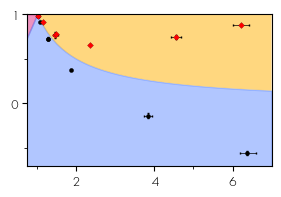

In [246]:
fig1b,ax1b = plt.subplots(figsize=(8/2.54,5/2.54))
plotted = bootstrapped_res[(bootstrapped_res.index.get_level_values('fileN') != 26.6)&(bootstrapped_res.index.get_level_values('fileN') != 0.01)]
curated = pd.read_csv('stoch_violator_bothint_rhocv.csv')
curated = curated[curated['fileN'] != 26.88]
ax1b.scatter(curated['E[CVx/CVy]'],curated['E[rhoxy]'],c='k',edgecolors='k',s=10,linewidths=0.1)
ax1b.scatter(plotted['E[CVx/CVy]'],plotted['E[rhoxy]'],
             marker='D',c='r',edgecolors='k',s=10,linewidths=0.1)

ax1b.errorbar(curated['E[CVx/CVy]'],curated['E[rhoxy]'],
                xerr=bsf.CV_bars(curated),
                yerr=bsf.rho_bars(curated),
                capsize=1,fmt='None',zorder=0,elinewidth=0.5,c='k',alpha=1,linewidth=0.5)

ax1b.errorbar(plotted['E[CVx/CVy]'],plotted['E[rhoxy]'],
                xerr=bsf.CV_bars(plotted),
                yerr=bsf.rho_bars(plotted),
                capsize=1,fmt='None',zorder=0,
                elinewidth=0.5,c='k',alpha=1,linewidth=0.5)

fx = curated['E[<F_x>]'].mean()
fy = curated['E[<F_y>]'].mean()


#constraint lines
straightline = np.linspace(0,1)
curvedline = np.linspace(1,7)

#positiveprotein
ax1b.fill_between(straightline,straightline,1,color='#DC267F',zorder=-1,alpha=0.5)
#negproteinbelow
ax1b.fill_between(np.concatenate([straightline,curvedline]),np.concatenate([straightline,1/curvedline]),-1,color='#648FFF',zorder=-1,alpha=0.5)
#negproteinabove
ax1b.fill_between(curvedline,1,1/curvedline,facecolor='#ffb000',zorder=-1,alpha=0.5)



ax1b.set_xticks([2,4,6])
ax1b.set_xticks([1,2,4,5,6],minor=True)
ax1b.set_xticklabels([r'2',r'4',r'6'],fontproperties=labelfont)

ax1b.set_yticks([0,1])
ax1b.set_yticks([-0.5,0.5],minor=True)
ax1b.set_yticklabels([r'0',r'1'],fontproperties=labelfont)

ax1b.set_xlim(0.75,7)
ax1b.set_ylim(-0.7,1)
fig1b.savefig('figures/Dec9/Direct_Indirect_rhocv_samesizes.pdf',bbox_inches='tight')

In [247]:
plotted

E[rhoxy]  \
fileN  fileda filedb sysname                                                   
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.767254   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.772834   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.745865   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.657404   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.879763   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0  0.911124   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.982464   

                                                                    2.5% (rhoxy)  \
fileN  fileda filedb sysname                                                       
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.729812   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.769122   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.726335   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.652520   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.870911   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0      0.899814   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.982040   

                                                                    50% (rhoxy)  \
fileN  fileda filedb sysname                                                      
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.770016   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.772925   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.746770   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.657543   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.879958   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0     0.911772   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.982468   

                                                                    97.5% (rhoxy)  \
fileN  fileda filedb sysname                                                        
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.794843   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.776210   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.762080   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.661934   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.887667   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0       0.919035   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.982866   

                                                                    E[CVx/CVy]  \
fileN  fileda filedb sysname                                                     
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.457524   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0    1.477865   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0    4.553384   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0    2.345946   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0    6.221069   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0    1.150648   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.025408   

                                                                    2.5% (CVx/CVy)  \
fileN  fileda filedb sysname                                                         
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0        1.396658   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0        1.468

In [248]:
curated

,fileN,fileda,filedb,sysname,E[rhoxy],2.5% (rhoxy),50% (rhoxy),97.5% (rhoxy),E[CVx/CVy],2.5% (CVx/CVy),...,beta_y,alpha,beta_z,nx,Kx,ny,Ky,offset,F_E<y>,F_E<x>
1,1.00,0.01,0.010,Data/IntHill_indirect_comp/12-30 1413/system_0,0.724881,0.707083,0.724532,0.745167,1.271809,1.244582,...,1,1,1,6,40,-5,20,0,-2.922866,0.768445
2,1.00,0.05,0.050,Data/IntHill_indirect_comp/12-30 1413/system_0,0.725757,0.721730,0.725713,0.729955,1.279119,1.273928,...,1,1,1,6,40,-5,20,0,-2.919705,0.773838
3,25.00,0.01,0.050,Data/IntHill_indirect_comp/12-30 1413/system_0,-0.136993,-0.161155,-0.136364,-0.112269,3.837534,3.740101,...,1,1,1,6,40,-5,20,0,-2.919658,0.769936
4,4.00,0.05,0.100,Data/IntHill_indirect_comp/12-30 1413/system_0,0.378884,0.374655,0.378961,0.382987,1.873370,1.863680,...,1,1,1,6,40,-5,20,0,-2.909426,0.778605
5,100.00,0.01,0.100,Data/IntHill_indirect_comp/12-30 1413/system_0,-0.558080,-0.580069,-0.561149,-0.530907,6.370100,6.190689,...,1,1,1,6,40,-5,20,0,-2.909302,0.775138
6,0.25,0.01,0.005,Data/IntHill_indirect_comp/12-30 1413/system_0,0.914068,0.908453,0.914131,0.919369,1.070476,1.055828,...,1,1,1,6,40,-5,20,0,-2.922982,0.769087
7,0.04,0.05,0.010,Data/IntHill_indirect_comp/12-30 1413/system_0,0.984710,0.984468,0.984707,0.984960,1.011945,1.010973,...,1,1,1,6,40,-5,20,0,-2.923002,0.772666


In [242]:
curated[['fileda','filedb','E[CVx/CVy]','E[rhoxy]']].to_latex('indirecty_res')

In [243]:
plotted.reset_index()[['fileda','filedb','E[CVx/CVy]','E[rhoxy]']].to_latex('directy_res')

In [244]:
plotted

E[rhoxy]  \
fileN  fileda filedb sysname                                                   
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.767254   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.772834   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.745865   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.657404   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.879763   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0  0.911124   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.982464   

                                                                    2.5% (rhoxy)  \
fileN  fileda filedb sysname                                                       
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.729812   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.769122   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.726335   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.652520   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.870911   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0      0.899814   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.982040   

                                                                    50% (rhoxy)  \
fileN  fileda filedb sysname                                                      
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.770016   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.772925   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.746770   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.657543   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.879958   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0     0.911772   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.982468   

                                                                    97.5% (rhoxy)  \
fileN  fileda filedb sysname                                                        
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.794843   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.776210   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.762080   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.661934   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.887667   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0       0.919035   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.982866   

                                                                    E[CVx/CVy]  \
fileN  fileda filedb sysname                                                     
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.457524   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0    1.477865   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0    4.553384   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0    2.345946   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0    6.221069   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0    1.150648   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.025408   

                                                                    2.5% (CVx/CVy)  \
fileN  fileda filedb sysname                                                         
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0        1.396658   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0        1.468

In [245]:
indirectdata = plotted.reset_index()[['fileda','filedb','E[CVx/CVy]','E[rhoxy]']].set_index(['fileda','filedb'])
directdata = curated[['fileda','filedb','E[CVx/CVy]','E[rhoxy]']].set_index(['fileda','filedb'])

merged = pd.merge(indirectdata,directdata,on=['fileda','filedb'],suffixes=('_ind','_dir'))
merged.sort_index().to_latex('bothy_res',float_format="%.2f")

In [222]:
plotted

E[rhoxy]  \
fileN  fileda filedb sysname                                                   
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.767254   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.772834   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0  0.745865   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.657404   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0  0.879763   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0  0.911124   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0  0.982464   
0.01   0.05   0.005  Data/Directy_largeNspread/08-08 1016/system_0  0.995358   

                                                                    2.5% (rhoxy)  \
fileN  fileda filedb sysname                                                       
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.729812   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.769122   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0      0.726335   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.652520   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0      0.870911   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0      0.899814   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0      0.982040   
0.01   0.05   0.005  Data/Directy_largeNspread/08-08 1016/system_0      0.995188   

                                                                    50% (rhoxy)  \
fileN  fileda filedb sysname                                                      
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.770016   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.772925   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0     0.746770   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.657543   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0     0.879958   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0     0.911772   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0     0.982468   
0.01   0.05   0.005  Data/Directy_largeNspread/08-08 1016/system_0     0.995361   

                                                                    97.5% (rhoxy)  \
fileN  fileda filedb sysname                                                        
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.794843   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.776210   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0       0.762080   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.661934   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0       0.887667   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0       0.919035   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0       0.982866   
0.01   0.05   0.005  Data/Directy_largeNspread/08-08 1016/system_0       0.995509   

                                                                    E[CVx/CVy]  \
fileN  fileda filedb sysname                                                     
1.00   0.01   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.457524   
       0.05   0.050  Data/Directy_largeNspread/08-08 1016/system_0    1.477865   
25.00  0.01   0.050  Data/Directy_largeNspread/08-08 1016/system_0    4.553384   
4.00   0.05   0.100  Data/Directy_largeNspread/08-08 1016/system_0    2.345946   
100.00 0.01   0.100  Data/Directy_largeNspread/08-08 1016/system_0    6.221069   
0.25   0.01   0.005  Data/Directy_largeNspread/08-08 1016/system_0    1.150648   
0.04   0.05   0.010  Data/Directy_largeNspread/08-08 1016/system_0    1.025408   
0.01  

In [225]:
curated

,fileN,fileda,filedb,sysname,E[rhoxy],2.5% (rhoxy),50% (rhoxy),97.5% (rhoxy),E[CVx/CVy],2.5% (CVx/CVy),...,beta_y,alpha,beta_z,nx,Kx,ny,Ky,offset,F_E<y>,F_E<x>
0,26.88,0.01,0.05185,Data/IntHill_indirect_comp/12-30 1801/system_0,-0.147293,-0.179567,-0.148706,-0.113133,3.986781,3.921462,...,1,1,1,6,40,-5,20,0,-2.919341,0.770024
1,1.00,0.01,0.01000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.724881,0.707083,0.724532,0.745167,1.271809,1.244582,...,1,1,1,6,40,-5,20,0,-2.922866,0.768445
2,1.00,0.05,0.05000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.725757,0.721730,0.725713,0.729955,1.279119,1.273928,...,1,1,1,6,40,-5,20,0,-2.919705,0.773838
4,4.00,0.05,0.10000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.378884,0.374655,0.378961,0.382987,1.873370,1.863680,...,1,1,1,6,40,-5,20,0,-2.909426,0.778605
5,100.00,0.01,0.10000,Data/IntHill_indirect_comp/12-30 1413/system_0,-0.558080,-0.580069,-0.561149,-0.530907,6.370100,6.190689,...,1,1,1,6,40,-5,20,0,-2.909302,0.775138
6,0.25,0.01,0.00500,Data/IntHill_indirect_comp/12-30 1413/system_0,0.914068,0.908453,0.914131,0.919369,1.070476,1.055828,...,1,1,1,6,40,-5,20,0,-2.922982,0.769087
7,0.04,0.05,0.01000,Data/IntHill_indirect_comp/12-30 1413/system_0,0.984710,0.984468,0.984707,0.984960,1.011945,1.010973,...,1,1,1,6,40,-5,20,0,-2.923002,0.772666


In [220]:
merged

E[CVx/CVy]_ind  E[rhoxy]_ind  E[CVx/CVy]_dir  E[rhoxy]_dir
fileda filedb                                                            
0.01   0.010         1.457524      0.767254        1.271809      0.724881
0.05   0.050         1.477865      0.772834        1.279119      0.725757
       0.100         2.345946      0.657404        1.873370      0.378884
0.01   0.100         6.221069      0.879763        6.370100     -0.558080
       0.005         1.150648      0.911124        1.070476      0.914068
0.05   0.010         1.025408      0.982464        1.011945      0.984710

In [ ]:
mmer

In [175]:
direx_file = 'Data/Directy_largeNspread/08-08 1016/system_0/nums_2.500e+01n1.000e-02n5.000e-02n0_data.csv'
direx = pd.read_csv(direx_file)

indirect_file = 'Data/IntHill_indirect_comp/12-30 1413/system_0/nums_2.500e+01n1.000e-02n5.000e-02n0_data.csv'
ex = pd.read_csv(indirect_file)

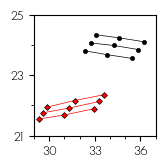

In [181]:

f,ax = plt.subplots(1,1,figsize=(4/2.54,4/2.54))

for triplet in [[6,0,3],[15,9,12],[24,18,21]]:
    ax.plot(ex['<x>'].iloc[triplet],ex['<y>'].iloc[triplet],
             color='k',marker='o',markeredgecolor='k',markerfacecolor='k',markersize=3,markeredgewidth=0.5,linewidth=0.5)
    ax.plot(direx['<x>'].iloc[triplet],direx['<y>'].iloc[triplet],
             color='r',marker='D',markeredgecolor='k',markerfacecolor='r',markersize=3,markeredgewidth=0.5,linewidth=0.5)

ax.set_xticks([30,33,36])
ax.set_xticks([29,31,32,34,35,37],minor=True)
ax.set_xticklabels([r'30',r'33',r'36'],fontproperties=labelfont)
ax.set_yticks([21,23,25])
ax.set_yticks([22,24],minor=True)
ax.set_yticklabels([r'21',r'23',r'25'],fontproperties=labelfont)
f.savefig('figures/Dec9/Direct_Indirect_xy.pdf',bbox_inches='tight')

In [138]:
ex

,fileN,fileda,filedb,perturbation,perturbation class,Exec Time,Sim Time,Steps,Flux Bal x,Flux Bal y,...,<y>,<z>,Var(x),Var(y),Var(z),Cov(xy),Cov(xz),Cov(yz),<F_x>,<F_y>
0,26.6,0.01,0.05158,0,lngn,93972,13148800.0,740269000.0,0.000557,0.000053,...,23.9664,0.760457,217.362,124.376,0.822121,143.466,4.06442,1.25909,1.03802,-1.074940
1,26.6,0.01,0.05158,1,lngn,93961,13150100.0,740009000.0,0.000177,0.000004,...,23.9542,0.760587,217.403,124.392,0.822708,143.505,4.07036,1.26357,1.03755,-1.075090
2,26.6,0.01,0.05158,2,lngn,94032,13150000.0,740501000.0,0.000436,0.000046,...,23.9729,0.760677,217.738,124.594,0.822667,143.751,4.07699,1.26797,1.03825,-1.074900
3,26.6,0.01,0.05158,3,lngu,98032,13765100.0,772620000.0,0.000019,0.000172,...,24.0663,0.726673,204.505,128.457,0.786863,141.815,3.81697,1.21282,1.04817,-1.151110
4,26.6,0.01,0.05158,4,lngu,100230,13775500.0,772290000.0,0.000440,0.000152,...,24.0381,0.726113,204.077,128.099,0.786326,141.451,3.81164,1.21078,1.04813,-1.152410
5,26.6,0.01,0.05158,5,lngu,97959,13774300.0,772220000.0,0.000054,0.000117,...,24.0374,0.725788,203.883,128.031,0.786109,141.318,3.80473,1.20481,1.04844,-1.152220
6,26.6,0.01,0.05158,6,lngd,89819,12528200.0,707114000.0,0.000293,0.000016,...,23.8344,0.797577,229.899,119.405,0.860202,144.002,4.30736,1.28898,1.02073,-1.001080
7,26.6,0.01,0.05158,7,lngd,89804,12530200.0,706924000.0,0.000058,0.000070,...,23.8208,0.797242,229.158,119.120,0.860203,143.537,4.29907,1.27895,1.02147,-1.001840
8,26.6,0.01,0.05158,8,lngd,89706,12531000.0,707257000.0,0.000062,0.000059,...,23.8308,0.797773,230.184,119.546,0.860826,144.191,4.31509,1.28966,1.01982,-1.000650
9,26.6,0.01,0.05158,9,lugn,94808,13139700.0,746854000.0,0.000320,0.000040,...,24.2018,0.760917,223.575,127.668,0.823920,147.744,4.16149,1.31617,1.04176,-1.068190


In [139]:
def lin_eta_xx(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*fy**2)/(1-fy-fx)**2
def lin_eta_yy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)**2)/(1-fy-fx)**2
def lin_eta_xy(eta_ll,eta_gg,fy,fx):
    return (eta_ll + eta_gg*(1-fx)*fy)/(1-fy-fx)**2


In [140]:
from matplotlib import markers as mplmarkers
def arrowtrace(ratiovals,fy,fx,ax1b,percentlocs=[0.2,0.3,0.45,0.6],colour='k'):
    r = lin_eta_xy(1,ratiovals,fy,fx)/np.sqrt(lin_eta_xx(1,ratiovals,fy,fx)*lin_eta_yy(1,ratiovals,fy,fx))
    c = np.sqrt(lin_eta_xx(1,ratiovals,fy,fx)/lin_eta_yy(1,ratiovals,fy,fx))
    dr = np.gradient(r)
    dc = np.gradient(c)
    rotation = np.degrees(np.arctan2(dr,dc))
    ax1b.plot(c,r,'--',color=colour,linewidth=1)
    for i in percentlocs:
        ind = np.int16(i*len(ratiovals))
        t = mplmarkers.MarkerStyle(marker='>')
        t._transform = t.get_transform().rotate_deg(rotation[ind])
        ax1b.scatter(c[ind],r[ind],marker=t,color=colour,s=10)


fig1b,ax1b = plt.subplots(figsize=(8/2.54,5/2.54))

ratiovals = np.logspace(-2,4,500)
#constraint lines
straightline = np.linspace(0,1)
curvedline = np.linspace(1,3)
#positiveprotein
ax1b.fill_between(straightline,straightline,1,color='#DC267F',zorder=-1,alpha=0.5)
#negproteinbelow
ax1b.fill_between(np.concatenate([straightline,curvedline]),np.concatenate([straightline,1/curvedline]),-1,color='#648FFF',zorder=-1,alpha=0.5)
#negproteinabove
ax1b.fill_between(curvedline,1,1/curvedline,facecolor='#ffb000',zorder=-1,alpha=0.5)


arrowtrace(ratiovals,-5,0,ax1b,[0.1,0.2,0.25])
arrowtrace(ratiovals,-3,0,ax1b,[0.12,0.25,0.375,0.5])
arrowtrace(ratiovals,-2,0,ax1b,[0.25,0.3,0.4,0.5])
arrowtrace(ratiovals,-1,0,ax1b,[0.2,0.3,0.4,0.5])
arrowtrace(ratiovals,-0.5,0,ax1b,[0.2,0.35,0.5,0.75])
arrowtrace(ratiovals,-0.1,0,ax1b,[0.36,0.5,0.6,0.75])


arrowtrace(ratiovals,0.3,0,ax1b,[0.3,0.45,0.55,0.7])
arrowtrace(ratiovals,0.1,0,ax1b,[0.36,0.45,0.55,0.7])
arrowtrace(ratiovals,0.05,0,ax1b,[0.45,0.6,0.7,0.9])
arrowtrace(ratiovals,0.5,0,ax1b,[0.5])


arrowtrace(ratiovals,0,0,ax1b,[0.3,0.2,0.4,0.5,0.7],'gray')

arrowtrace(ratiovals,-1.1,1,ax1b,[0.3,0.38,0.42,0.46],'gray')

arrowtrace(ratiovals,-2,1.25,ax1b,[0.2,0.28,0.34,0.38])
arrowtrace(ratiovals,-5,3,ax1b,[0.1,0.2,0.28,0.38])


#Set axes
ax1b.set_xticks([1,2,3])
ax1b.set_xticks([0.5,1.5,2.5],minor=True)
ax1b.set_xticklabels([r'1',r'2',r'3'],fontproperties=labelfont)

ax1b.set_yticks([-1,0,1])
ax1b.set_yticks([-0.5,0.5],minor=True)
ax1b.set_yticklabels([r'-1',r'0',r'1'],fontproperties=labelfont)

ax1b.set_xlim(0,3)
ax1b.set_ylim(-1,1)
#fig1b.savefig('figures/supplement/phasediagram.pdf',format='pdf')

In [142]:
pdist = pd.read_csv('/Users/seshu/Library/CloudStorage/OneDrive-UniversityofToronto/HillFunctionPerturbation/Data/Directy_largeNspread/08-08 1744/system_0/da_1.000e-02_db_5.158e-02_sys_0_pert_0_pdist.csv')

In [143]:
dist = pdist.groupby(['x','y']).sum().sort_index()['p']

In [144]:
np.argmax(dist)

np.int64(665)

In [145]:
dist

x    y 
8    5     2.818230e-08
     6     3.863910e-08
     7     5.318000e-08
     8     3.017500e-08
     9     7.339350e-09
               ...     
138  87    4.144600e-09
     88    5.337730e-10
     89    3.359830e-09
     90    3.103550e-10
139  86    1.629750e-09
Name: p, Length: 7442, dtype: float64

In [146]:
dist.iloc[664:666]

x   y 
27  18    0.006233
    19    0.006258
Name: p, dtype: float64

In [147]:
dist.explode().sort_index()

x    y 
8    5     2.818230e-08
     6     3.863910e-08
     7     5.318000e-08
     8     3.017500e-08
     9     7.339350e-09
               ...     
138  87    4.144600e-09
     88    5.337730e-10
     89    3.359830e-09
     90    3.103550e-10
139  86    1.629750e-09
Name: p, Length: 7442, dtype: float64

In [148]:
X

array([[  8,   9,  10, ..., 137, 138, 139],
       [  8,   9,  10, ..., 137, 138, 139],
       [  8,   9,  10, ..., 137, 138, 139],
       ...,
       [  8,   9,  10, ..., 137, 138, 139],
       [  8,   9,  10, ..., 137, 138, 139],
       [  8,   9,  10, ..., 137, 138, 139]])

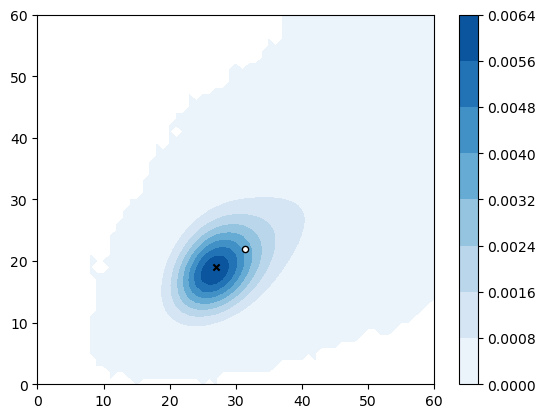

In [190]:
example = dist.reset_index()

X,Y = np.meshgrid(example['x'].sort_values().unique(),
                  example['y'].sort_values().unique())

g = plt.contourf(X,Y,example.pivot(columns='x',index='y',
                         values='p'),cmap='Blues',vmin=0,vmax=0.007)
modeloc = np.argmax(example['p'])
mode = example.iloc[modeloc]
means = example['x'].dot(example['p']),example['y'].dot(example['p'])
plt.scatter(mode['x'],mode['y'],color='k',s=20,marker='x')
plt.scatter(means[0],means[1],color='w',s=20,edgecolors='k')
plt.colorbar(g)
plt.xlim(0,60)
plt.ylim(0,60)
plt.savefig('figures/directindirectcompare/pdist_example_direct.pdf',format='pdf')

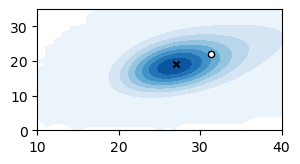

In [200]:
example = dist.reset_index()
f,ax = plt.subplots(figsize=(8/2.54,4/2.54))
X,Y = np.meshgrid(example['x'].sort_values().unique(),
                  example['y'].sort_values().unique())

g = plt.contourf(X,Y,example.pivot(columns='x',index='y',
                         values='p'),cmap='Blues',vmin=0,vmax=0.007)
modeloc = np.argmax(example['p'])
mode = example.iloc[modeloc]
means = example['x'].dot(example['p']),example['y'].dot(example['p'])
plt.scatter(mode['x'],mode['y'],color='k',s=20,marker='x')
plt.scatter(means[0],means[1],color='w',s=20,edgecolors='k')
plt.xlim(10,40)
plt.ylim(0,35)
plt.savefig('figures/directindirectcompare/pdist_example_direct_justdist.pdf',format='pdf')

In [150]:
example.iloc[665]

x    27.000000
y    19.000000
p     0.006258
Name: 665, dtype: float64

In [151]:
np.argmax(example['p'])

np.int64(665)

In [152]:
mode

x    27.000000
y    19.000000
p     0.006258
Name: 665, dtype: float64

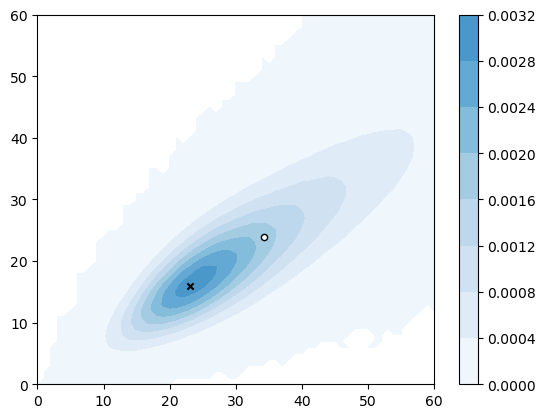

In [189]:
indirdist = pd.read_csv('Data/IntHill_consistent_viol_paramratio_dists/11-15 0949/system_0/da_1.000e-01_db_1.000e-01_sys_0_pert_0_pdist.csv')
dist2 = indirdist.groupby(['x','y']).sum().sort_index()['p']
example2 = dist2.reset_index()
X2,Y2 = np.meshgrid(example2['x'].sort_values().unique(),
                  example2['y'].sort_values().unique())

i = plt.contourf(X2,Y2,example2.pivot(columns='x',index='y',
                         values='p'),cmap='Blues',vmin=0,vmax=0.005)
modeloc = np.argmax(example2['p'])
mode = example2.iloc[modeloc]
means = example2['x'].dot(example2['p']),example2['y'].dot(example2['p'])
plt.scatter(mode['x'],mode['y'],color='k',s=20,marker='x')
plt.scatter(means[0],means[1],color='w',s=20,edgecolors='k')
plt.colorbar(i)
plt.xlim(0,60)
plt.ylim(0,60)
plt.savefig('figures/directindirectcompare/pdist_example_indirect.pdf',format='pdf')

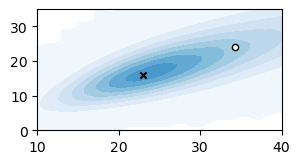

In [199]:
indirdist = pd.read_csv('Data/IntHill_consistent_viol_paramratio_dists/11-15 0949/system_0/da_1.000e-01_db_1.000e-01_sys_0_pert_0_pdist.csv')
dist2 = indirdist.groupby(['x','y']).sum().sort_index()['p']
example2 = dist2.reset_index()
X2,Y2 = np.meshgrid(example2['x'].sort_values().unique(),
                  example2['y'].sort_values().unique())
f,ax = plt.subplots(figsize=(8/2.54,4/2.54))
i = plt.contourf(X2,Y2,example2.pivot(columns='x',index='y',
                         values='p'),cmap='Blues',vmin=0,vmax=0.005)
modeloc = np.argmax(example2['p'])
mode = example2.iloc[modeloc]
means = example2['x'].dot(example2['p']),example2['y'].dot(example2['p'])
plt.scatter(mode['x'],mode['y'],color='k',s=20,marker='x')
plt.scatter(means[0],means[1],color='w',s=20,edgecolors='k')
plt.xlim(10,40)
plt.ylim(0,35)
plt.savefig('figures/directindirectcompare/pdist_example_indirect_jsutdist.pdf',format='pdf')

<Axes: xlabel='z'>

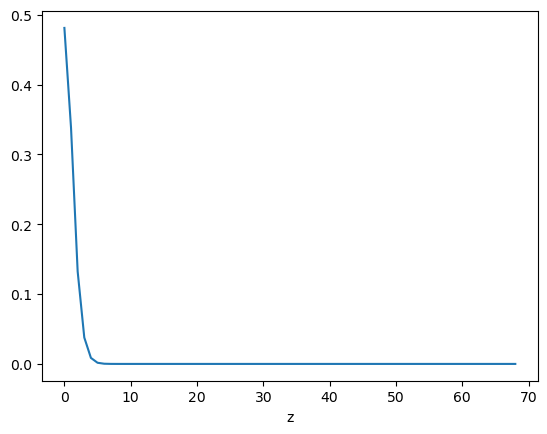

In [154]:
indirdist.groupby('z')['p'].sum().plot()